# [Intermediate earth data science textbook](https://www.earthdatascience.org/courses/use-data-open-source-python/)
## Use Data for Earth and Environmental Science in Open Source Python
Tutorial Author: Earth Lab CU Boulder <br>
Name: Geoff Tam <br>
Date Created: 09-03-2022 <br>

## [Section 4. Spatial Data Applications in Python](https://www.earthdatascience.org/courses/use-data-open-source-python/spatial-data-applications/)

### Chapter 6. Uncertainty in Remote Sensing Data

#### [Lesson 2. Extract Raster Values at Point Locations in Python](https://www.earthdatascience.org/courses/use-data-open-source-python/spatial-data-applications/lidar-remote-sensing-uncertainty/extract-data-from-raster/)

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.ma as ma
import pandas as pd
import rioxarray as rxr
from rasterio.plot import plotting_extent
import geopandas as gpd
# Rasterstats contains the zonalstatistics function
# that you will use to extract raster values
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep

# Set consistent plotting style
sns.set_style("white")
sns.set(font_scale=1.5)

In [2]:
# Set working directory
os.chdir(os.path.join(et.io.HOME,
                    'Documents',
                    'learning',
                      'earth-analytics',
                      'data'))

In [3]:
# Load and plot canopy height model 
sjer_lidar_chm_path = os.path.join("spatial-vector-lidar",
                                    "california",
                                    "neon-sjer-site",
                                    "2013",
                                    "lidar",
                                    "SJER_lidarCHM.tif")

sjer_chm_data = rxr.open_rasterio(sjer_lidar_chm_path, masked = True).squeeze()

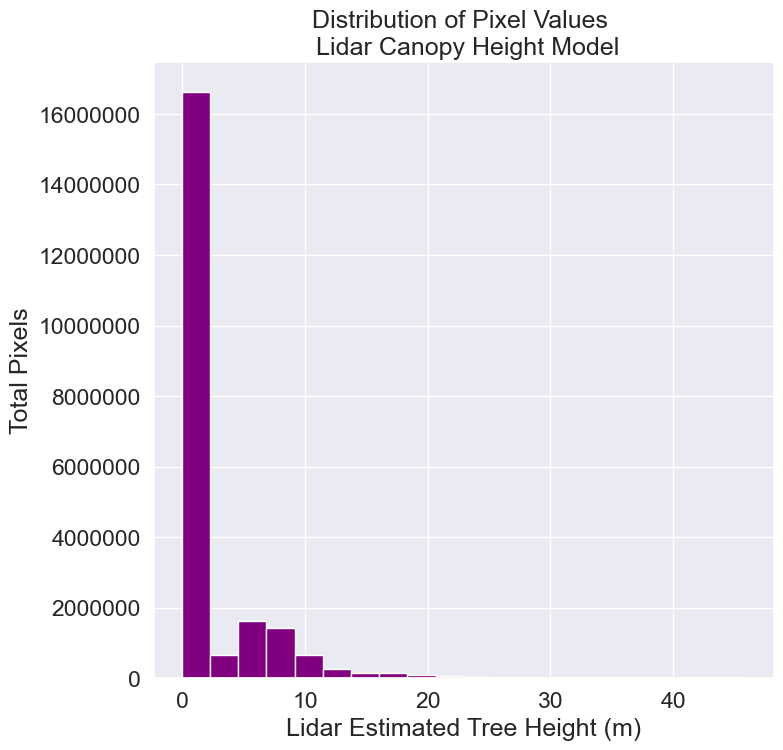

In [4]:
# Histogram
ax = ep.hist(sjer_chm_data.values,
            figsize=(8,8),
            colors="purple",
            xlabel="Lidar Estimated Tree Height (m)",
            ylabel="Total Pixels",
            title="Distribution of Pixel Values \n Lidar Canopy Height Model")

# Turn off scientific notation
ax[1].ticklabel_format(useOffset=False,
                        style='plain')

In [5]:
# EXPLORE: View summary statistics of canopy height model
# Notice hte mean value with 0's included in the data
print('Mean:', sjer_chm_data.mean().values)
print('Max:', sjer_chm_data.max().values)
print('Min:', sjer_chm_data.min().values)

Mean: 1.9355862
Max: 45.879997
Min: 0.0


In [6]:
# CLEANUP: Set CHM values of 0 to NAN (no data or not a number)
sjer_chm_data_no_zeros = sjer_chm_data.where(sjer_chm_data != 0, np.nan)

# View summary statistics of canopy height model after removing zeros 
print('Mean:', sjer_chm_data_no_zeros.mean().values)
print('Max:', sjer_chm_data_no_zeros.max().values)
print('Min:', sjer_chm_data_no_zeros.min().values)

Mean: 8.213505
Max: 45.879997
Min: 2.0


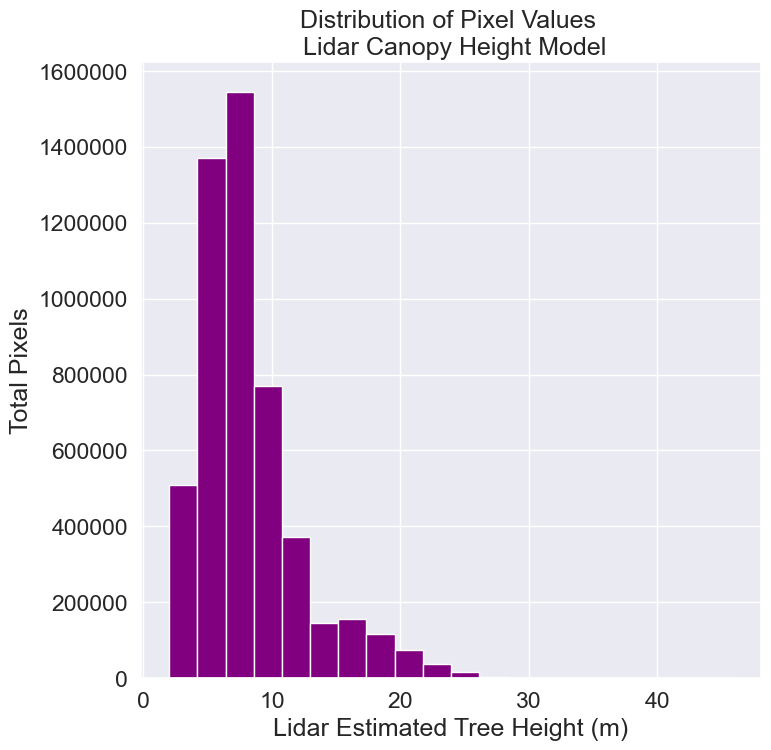

In [7]:
# Histogram of clean data
ax = ep.hist(sjer_chm_data_no_zeros.values,
            figsize=(8,8),
            colors='purple',
            xlabel='Lidar Estimated Tree Height (m)',
            ylabel='Total Pixels',
            title='Distribution of Pixel Values \n Lidar Canopy Height Model')
            
# Turn off scientific notation
ax[1].ticklabel_format(useOffset=False,
                    style='plain')

In [8]:
# Import manual tree points shapefile
sjer_centroids_path = os.path.join('spatial-vector-lidar',
                                    'california',
                                    'neon-sjer-site',
                                    'vector_data',
                                    'SJER_plot_centroids.shp')

sjer_plots_points = gpd.read_file(sjer_centroids_path)

type(sjer_plots_points)

geopandas.geodataframe.GeoDataFrame

In [9]:
# Ensure this points layer 
sjer_plots_points.geom_type.head()

0    Point
1    Point
2    Point
3    Point
4    Point
dtype: object

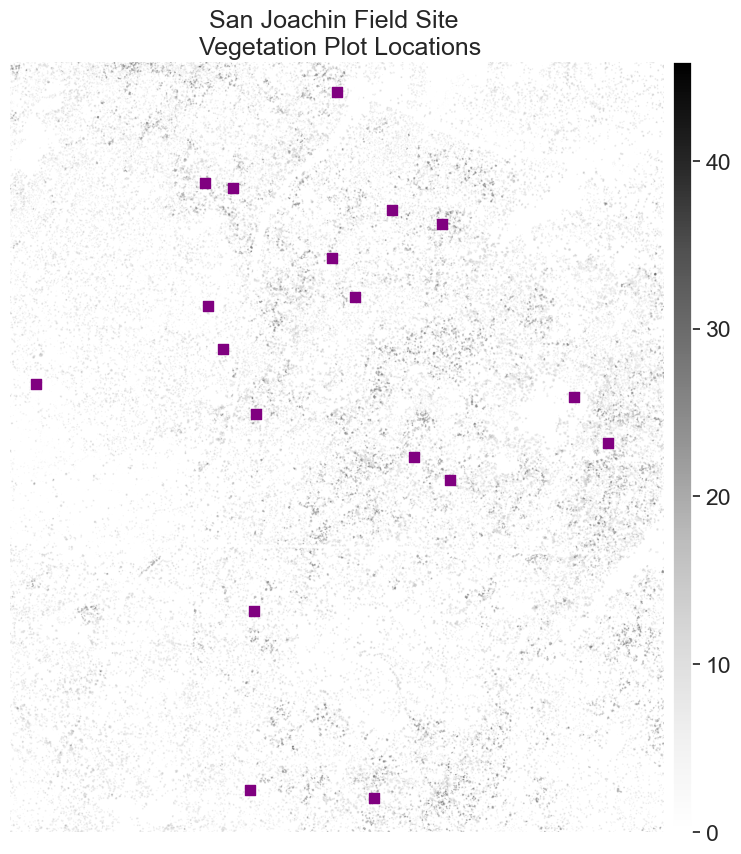

In [10]:
fig, ax = plt.subplots(figsize=(10,10))

# Plot with the zeros so CHM can be well represented visually 
ep.plot_bands(sjer_chm_data,
            extent=plotting_extent(sjer_chm_data,
                        sjer_chm_data.rio.transform()),
            cmap='Greys',
            title='San Joachin Field Site \n Vegetation Plot Locations',
            scale=False,
            ax=ax)
            
sjer_plots_points.plot(ax=ax,
                    marker='s',
                    markersize=45,
                    color='purple')
                    
ax.set_axis_off()
plt.show()

In [11]:
# Create buffered polygon layer from plot location points
sjer_plots_poly = sjer_plots_points.copy()

# Buffer each point using a 20 m circle radius
# replace the point geometry with the new buffers
sjer_plots_poly['geometry']= sjer_plots_points.geometry.buffer(20)
sjer_plots_poly.head()

,Plot_ID,Point,northing,easting,plot_type,geometry
0,SJER1068,center,4111567.818,255852.376,trees,"POLYGON ((255872.376 4111567.818, 255872.280 4..."
1,SJER112,center,4111298.971,257406.967,trees,"POLYGON ((257426.967 4111298.971, 257426.871 4..."
2,SJER116,center,4110819.876,256838.760,grass,"POLYGON ((256858.760 4110819.876, 256858.664 4..."
3,SJER117,center,4108752.026,256176.947,trees,"POLYGON ((256196.947 4108752.026, 256196.851 4..."
4,SJER120,center,4110476.079,255968.372,grass,"POLYGON ((255988.372 4110476.079, 255988.276 4..."


In [6]:
# Create output path if doesn't exist
output_path = os.path.join('spatial-vector-lidar',
                           'outputs')

if not os.path.isdir(output_path):
    os.mkdir(output_path)

# Export the buffered point layer as a shapefile to use in zonal stats
plot_buffer_path = os.path.join(output_path,
                        'plot_buffer.shp')
                        
sjer_plots_poly.to_file(plot_buffer_path)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'spatial-vector-lidar\\outputs'

In [13]:
# Extract zonal stats
# Geoff Note: pulling the heights off all the trees (non zero values) that fall within buffer polygons 
sjer_tree_heights = rs.zonal_stats(plot_buffer_path,
                                    sjer_chm_data_no_zeros.values,
                                    nodata=-999,
                                    affine=sjer_chm_data_no_zeros.rio.transform(),
                                    geojson_out=True,
                                    copy_properties=True,
                                    stats='count min mean max median')

# View object type
type(sjer_tree_heights)

list

In [14]:
# Turn extrated data into a pandas geodataframe
sjer_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_tree_heights)
sjer_lidar_height_df.head()

,geometry,Plot_ID,Point,northing,easting,plot_type,min,max,mean,count,median
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,4111567.818,255852.376,trees,2.04,19.049999,11.544347,161,12.62
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,4111298.971,257406.967,trees,2.10,24.019999,10.369277,443,7.87
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,4110819.876,256838.760,grass,2.82,16.070000,7.518398,643,6.80
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,4108752.026,256176.947,trees,3.24,11.059999,7.675346,245,7.93
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,4110476.079,255968.372,grass,3.38,5.740000,4.591177,17,4.45


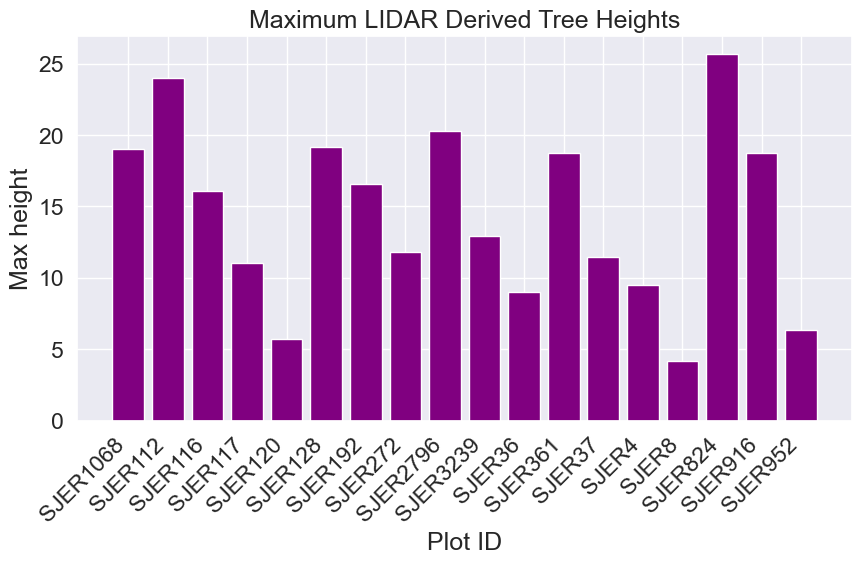

In [15]:
# Bar plot of max lidar derived tree heights by plot id
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(sjer_lidar_height_df['Plot_ID'],
        sjer_lidar_height_df['max'],
        color='purple')
        
ax.set(xlabel='Plot ID',
    ylabel='Max height',
    title='Maximum LIDAR Derived Tree Heights')

plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [16]:
# Extract zonal stats but retain the individual pixel values 
sjer_tree_heights_ras = rs.zonal_stats(plot_buffer_path,
                                    sjer_chm_data_no_zeros.values,
                                    nodata=-999,
                                    affine=sjer_chm_data_no_zeros.rio.transform(),
                                    geojson_out=True,
                                    raster_out=True,
                                    copy_properties=True,
                                    stats='count min mean max median')

# Convert to geodataframe
sjer_lidar_height_df_ras = gpd.GeoDataFrame.from_features(
    sjer_tree_heights_ras)

# View subste of the dataframe
sjer_lidar_height_df_ras[["Plot_ID",
                        'count',
                        'geometry',
                        'mini_raster_affine',
                        'mini_raster_array']].head()

,Plot_ID,count,geometry,mini_raster_affine,mini_raster_array
0,SJER1068,161,"POLYGON ((255872.376 4111567.818, 255872.280 4...","(1.0, 0.0, 255832.0, 0.0, -1.0, 4111588.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."
1,SJER112,443,"POLYGON ((257426.967 4111298.971, 257426.871 4...","(1.0, 0.0, 257386.0, 0.0, -1.0, 4111319.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."
2,SJER116,643,"POLYGON ((256858.760 4110819.876, 256858.664 4...","(1.0, 0.0, 256818.0, 0.0, -1.0, 4110840.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."
3,SJER117,245,"POLYGON ((256196.947 4108752.026, 256196.851 4...","(1.0, 0.0, 256156.0, 0.0, -1.0, 4108773.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."
4,SJER120,17,"POLYGON ((255988.372 4110476.079, 255988.276 4...","(1.0, 0.0, 255948.0, 0.0, -1.0, 4110497.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."


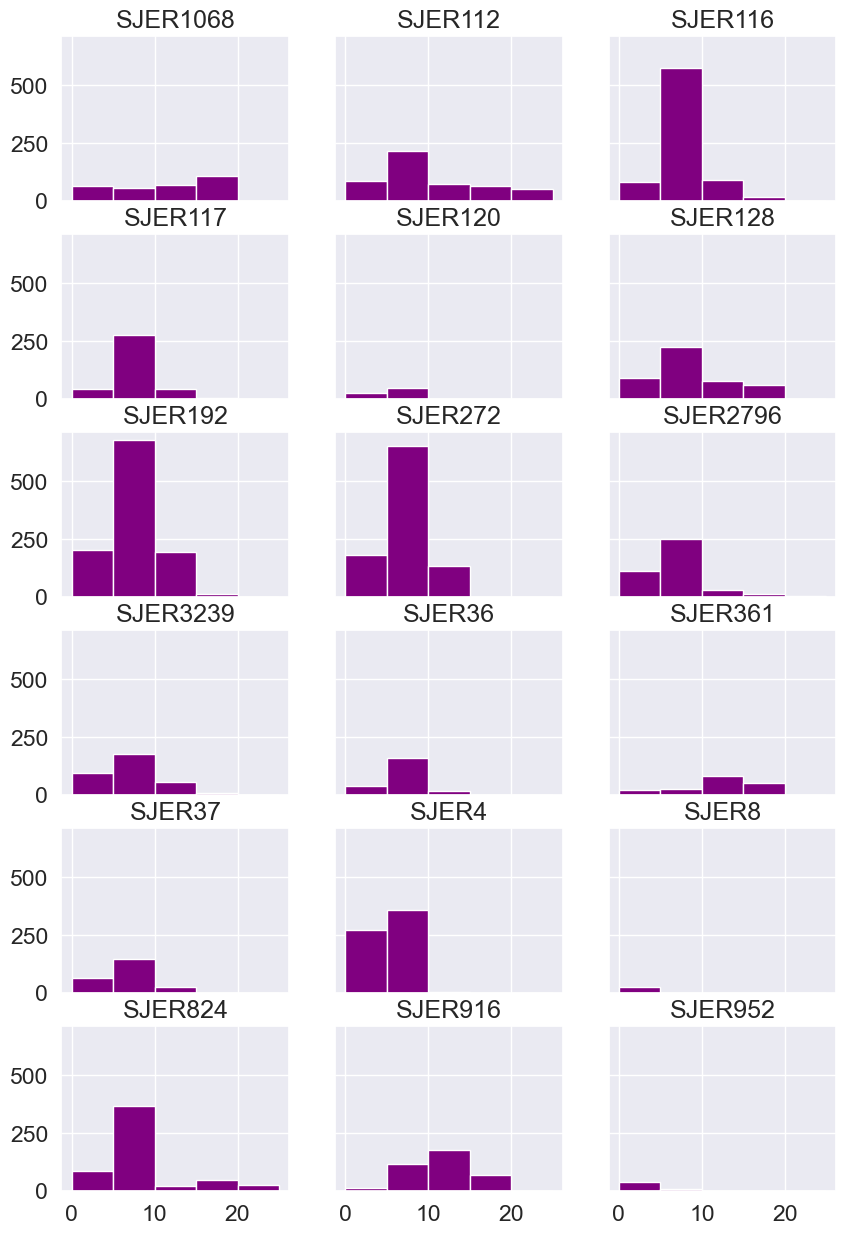

In [19]:
# Get list of sites
site_names = list(sjer_lidar_height_df_ras['Plot_ID'])

# Convert data in dataframe to a numpy array
arr = np.stack(sjer_lidar_height_df_ras['mini_raster_array'])

# Plot using earthpy 
ep.hist(arr,
        bins=[0, 5, 10, 15, 20, 25],
        cols=3, 
        title=site_names,
        figsize=(10, 15))
        
plt.show()

#### [Lesson 3. Compare Lidar to Measured Tree Height](https://www.earthdatascience.org/courses/use-data-open-source-python/spatial-data-applications/lidar-remote-sensing-uncertainty/summarize-and-compare-lidar-insitu-tree-height/) 

In [7]:
# Load libraries 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import rioxarray as rxr
from rasterio.plot import plotting_extent
import geopandas as gpd
import rasterstats as rs
from earthpy import spatial as es
import earthpy as et
import earthpy.plot as ep

# Setting consistent plotting style throughout notebook
sns.set_style("white")
sns.axes_style("white")
sns.set(font_scale=1.5)

In [14]:
# Set working directory
os.chdir(os.path.join(et.io.HOME,
                    'Documents',
                    'learning',
                      'earth-analytics',
                      'data'))

In [15]:
# Load lidar canopy data
sjer_lidar_chm_path = os.path.join("spatial-vector-lidar",
                                   "california",
                                   "neon-sjer-site",
                                   "2013",
                                   "lidar",
                                   "SJER_lidarCHM.tif")

# Load data
sjer_chm_data = rxr.open_rasterio(sjer_lidar_chm_path, masked=True).squeeze()

plot_buffer_path = os.path.join('spatial-vector-lidar',
                                'outputs',
                                'plot_buffer.shp')

# Extract zonal stats & create geodataframe
sjer_tree_heights = rs.zonal_stats(plot_buffer_path,
                                   sjer_chm_data.values,
                                   affine=sjer_chm_data.rio.transform(),
                                   geojson_out=True,
                                   copy_properties=True,
                                   nodata=0,
                                   stats="count mean max")

sjer_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_tree_heights)

In [42]:
# Import & view insitu (field measured) data
path_insitu = os.path.join("spatial-vector-lidar",
                           "california",
                           "neon-sjer-site",
                           "2013",
                           "insitu",
                           "veg_structure",
                           "D17_2013_SJER_vegStr.csv")

sjer_insitu_all = pd.read_csv(path_insitu)

# View columns in data
sjer_insitu_all.columns

Index(['siteid', 'sitename', 'plotid', 'easting', 'northing', 'taxonid',
       'scientificname', 'indvidual_id', 'pointid', 'individualdistance',
       'individualazimuth', 'dbh', 'dbhheight', 'basalcanopydiam',
       'basalcanopydiam_90deg', 'maxcanopydiam', 'canopydiam_90deg',
       'stemheight', 'stemremarks', 'stemstatus', 'canopyform', 'livingcanopy',
       'inplotcanopy', 'materialsampleid', 'dbhqf', 'stemmapqf', 'plant_group',
       'common_name', 'aop_plot', 'unique_id'],
      dtype='object')

In [43]:
# Subset in situ dataframe
sjer_insitu = sjer_insitu_all[["siteid",
                               "sitename",
                               "plotid",
                               "stemheight",
                               "scientificname"]]

sjer_insitu.head()

,siteid,sitename,plotid,stemheight,scientificname
0,SJER,San Joaquin,SJER128,18.2,Pinus sabiniana
1,SJER,San Joaquin,SJER2796,3.3,Arctostaphylos viscida
2,SJER,San Joaquin,SJER272,1.7,Arctostaphylos viscida
3,SJER,San Joaquin,SJER112,2.1,Arctostaphylos viscida
4,SJER,San Joaquin,SJER272,3.0,Arctostaphylos viscida


In [44]:
# Find max tree height by unique plot
insitu_stem_ht = sjer_insitu.groupby('plotid').agg(['mean', 'max'])['stemheight']

insitu_stem_ht.head()

C:\Users\geoff\AppData\Local\Temp\ipykernel_23008\3526277715.py:2: FutureWarning: ['siteid', 'sitename', 'scientificname'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  insitu_stem_ht = sjer_insitu.groupby('plotid').agg(['mean', 'max'])['stemheight']


,mean,max
plotid,,
SJER1068,3.866667,19.3
SJER112,8.221429,23.9
SJER116,8.218750,16.0
SJER117,6.512500,11.0
SJER120,7.600000,8.8


In [45]:
# Append column names before merging to Lidar dataframe
insitu_stem_ht.rename(columns={"mean":"insitu_mean",
                            "max":"insitu_max"},
                            inplace=True) # Modify the datframe columns

insitu_stem_ht.head()

,insitu_mean,insitu_max
plotid,,
SJER1068,3.866667,19.3
SJER112,8.221429,23.9
SJER116,8.218750,16.0
SJER117,6.512500,11.0
SJER120,7.600000,8.8


In [46]:
# Reset the index to plotid
insitu_stem_ht = insitu_stem_ht.reset_index()
insitu_stem_ht.head()

,plotid,insitu_mean,insitu_max
0,SJER1068,3.866667,19.3
1,SJER112,8.221429,23.9
2,SJER116,8.218750,16.0
3,SJER117,6.512500,11.0
4,SJER120,7.600000,8.8


 Merge insitu data with spatial dataframe

In [47]:
# Rename columns in lidar df
sjer_lidar_height_df = sjer_lidar_height_df.rename(columns={'max': 'lidar_max', 
                                                            'mean':'lidar_mean',
                                                            'min':'lidar_min'})

# Join lidar and human measured tree height data
sjer_final_height = sjer_lidar_height_df.merge(insitu_stem_ht,
                                                left_on='Plot_ID',
                                                right_on='plotid')

sjer_final_height.head()

,geometry,Plot_ID,Point,northing,easting,plot_type,lidar_max,lidar_mean,count,plotid,insitu_mean,insitu_max
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,4111567.818,255852.376,trees,19.049999,11.544347,161,SJER1068,3.866667,19.3
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,4111298.971,257406.967,trees,24.019999,10.369277,443,SJER112,8.221429,23.9
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,4110819.876,256838.760,grass,16.070000,7.518398,643,SJER116,8.218750,16.0
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,4108752.026,256176.947,trees,11.059999,7.675346,245,SJER117,6.512500,11.0
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,4110476.079,255968.372,grass,5.740000,4.591177,17,SJER120,7.600000,8.8


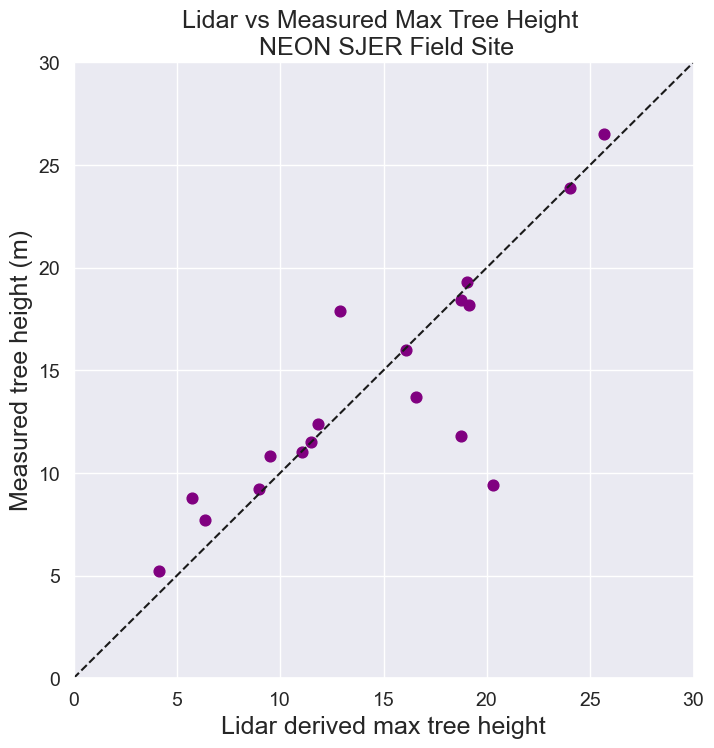

In [48]:
# Convert to a dataframe for pandas plot
sjer_final_height_df = pd.DataFrame(sjer_final_height)

fig, ax = plt.subplots(figsize=(8,8))

sjer_final_height_df.plot('lidar_max',
                        'insitu_max',
                        kind='scatter',
                        fontsize=14, s= 60,
                        color='purple',
                        ax=ax)

ax.set(xlabel='Lidar derived max tree height',
        ylabel='Measured tree height (m)',
        title='Lidar vs Measured Max Tree Height \n NEON SJER Field Site')

# Add 1:1 line
ax.plot((0,1), (0,1),
    transform=ax.transAxes, ls='--', c='k')

# Adjust x and y axes limits
ax.set(xlim=[0,30], ylim=[0,30])
plt.show()

Map of plots with markersize reflecting tree height


In [49]:
# Convert the geometry column to contain points
sjer_final_height['geometry'] = sjer_final_height.centroid
sjer_final_height.head()

sjer_final_height['insitu_max']

0     19.3
1     23.9
2     16.0
3     11.0
4      8.8
5     18.2
6     13.7
7     12.4
8      9.4
9     17.9
10     9.2
11    11.8
12    11.5
13    10.8
14     5.2
15    26.5
16    18.4
17     7.7
Name: insitu_max, dtype: float64

Plot points by tree height

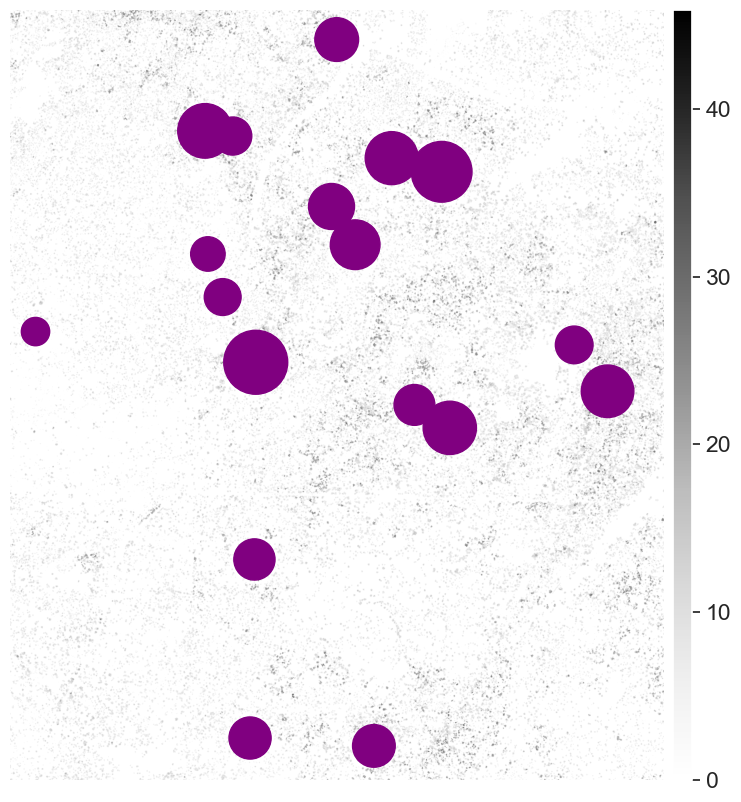

In [50]:
fig, ax = plt.subplots(figsize=(10,10))

# Lidar raster
ep.plot_bands(sjer_chm_data,
            cmap='Greys',
            extent=plotting_extent(sjer_chm_data,
            sjer_chm_data.rio.transform()),
            ax=ax,
            scale=False)

# Plot centroids of each geometry as points
sjer_final_height.centroid.plot(ax=ax,
                                marker='o',
                                markersize=sjer_final_height['insitu_max']*80,
                                c='purple')

ax.set_axis_off()
plt.show()

Difference plot lidar vs measured

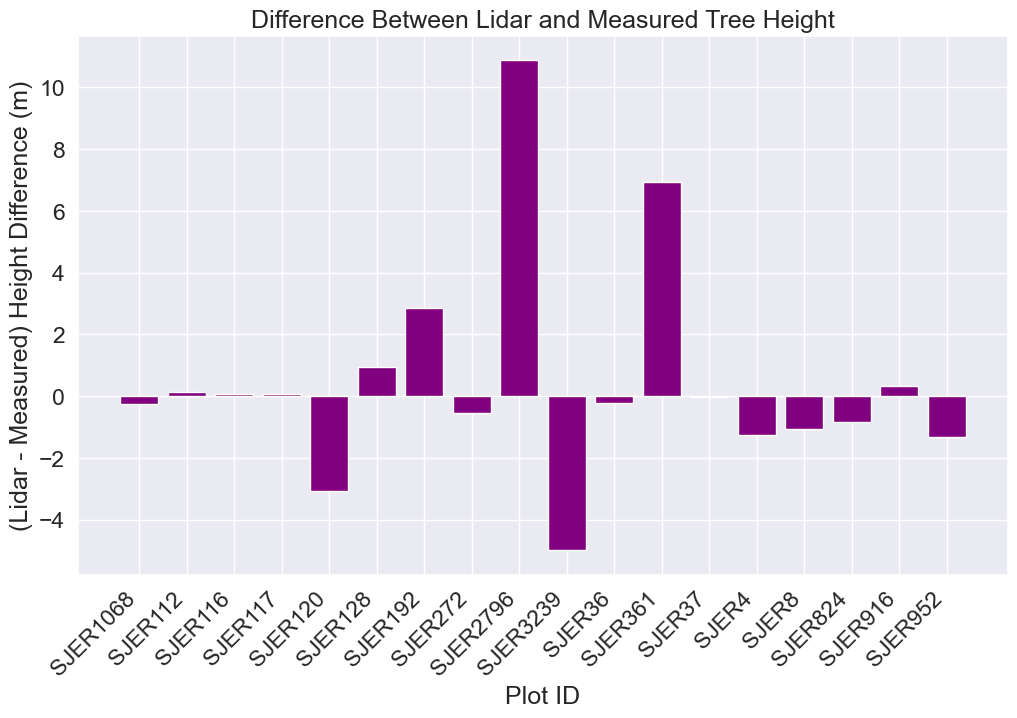

In [52]:
# Calculate difference
sjer_final_height['lidar_measured'] = sjer_final_height['lidar_max'] - sjer_final_height['insitu_max']

# Create a bar plot
fig, ax = plt.subplots(figsize=(12,7))
ax.bar(sjer_final_height['plotid'],
        sjer_final_height['lidar_measured'],
        color='purple')

ax.set(xlabel='Plot ID', 
    ylabel="(Lidar - Measured) Height Difference (m)",
    title="Difference Between Lidar and Measured Tree Height")

plt.setp(ax.get_xticklabels(),
    rotation=45, horizontalalignment='right')

plt.show()

#### [Lesson 4. Regression Analysis to Explore Data Relationships & Bad Data](https://www.earthdatascience.org/courses/use-data-open-source-python/spatial-data-applications/lidar-remote-sensing-uncertainty/compare-lidar-and-measured-tree-height-regression/)

In [56]:
import os
from math import *

# Importing stats from scipy for regression calculations
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import rioxarray as rxr
import geopandas as gpd
import rasterstats as rs
import earthpy as et

# Setting consistent plotting style throughout notebook
sns.set_style("white")
sns.set(font_scale=1.5)

In [57]:
sjer_final_height_df

,geometry,Plot_ID,Point,northing,easting,plot_type,lidar_max,lidar_mean,count,plotid,insitu_mean,insitu_max,lidar_measured
0,POINT (255852.376 4111567.818),SJER1068,center,4111567.818,255852.376,trees,19.049999,11.544347,161,SJER1068,3.866667,19.3,-0.250001
1,POINT (257406.967 4111298.971),SJER112,center,4111298.971,257406.967,trees,24.019999,10.369277,443,SJER112,8.221429,23.9,0.119999
2,POINT (256838.760 4110819.876),SJER116,center,4110819.876,256838.760,grass,16.070000,7.518398,643,SJER116,8.218750,16.0,0.070000
3,POINT (256176.947 4108752.026),SJER117,center,4108752.026,256176.947,trees,11.059999,7.675346,245,SJER117,6.512500,11.0,0.059999
4,POINT (255968.372 4110476.079),SJER120,center,4110476.079,255968.372,grass,5.740000,4.591177,17,SJER120,7.600000,8.8,-3.060000
5,POINT (257078.867 4111388.570),SJER128,center,4111388.570,257078.867,trees,19.139999,8.987087,381,SJER128,5.211765,18.2,0.939999
6,POINT (256683.434 4111071.087),SJER192,center,4111071.087,256683.434,grass,16.549999,7.229096,929,SJER192,6.769565,13.7,2.849999
7,POINT (256717.467 4112167.778),SJER272,center,4112167.778,256717.467,trees,11.840000,7.107061,711,SJER272,6.819048,12.4,-0.560000
8,POINT (256034.390 4111533.879),SJER2796,center,4111533.879,256034.390,soil,20.279999,6.409630,270,SJER2796,5.085714,9.4,10.879999
9,POINT (258497.102 4109856.983),SJER3239,center,4109856.983,258497.102,soil,12.910000,6.009128,195,SJER3239,3.920833,17.9,-4.990000


In [58]:
x = sjer_final_height_df.lidar_max
y = sjer_final_height_df.insitu_max

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2)

slope: 0.7607314439776315 
intercept: 2.98146647443445 
r squared: 0.6910551716430489


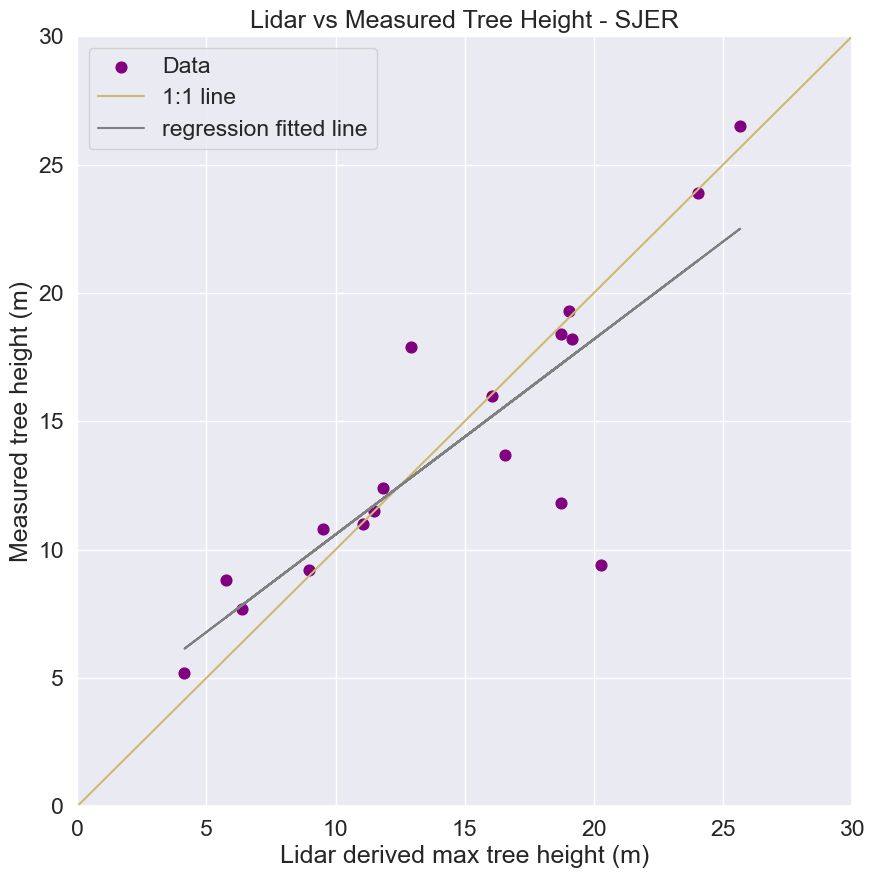

In [60]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 10))

m = slope.astype(float)

sjer_final_height_df.plot('lidar_max',
                          'insitu_max',
                          kind='scatter',
                          color="purple",
                          s=60,
                          ax=ax,
                          label="Data")

# Add a diagonal line
ax.set(xlim=[0, 30], ylim=[0, 30])
ax.plot((0, 1), (0, 1), 'y-', transform=ax.transAxes, label="1:1 line")
ax.plot(x, m*x + intercept, 'grey', label='regression fitted line')

ax.set(xlabel="Lidar derived max tree height (m)",
       ylabel="Measured tree height (m)",
       title="Lidar vs Measured Tree Height - SJER")

plt.legend()
plt.show()

Good fit, large intercept can indicate a strong relationship but variables measuring different things

slope: 1.0 
intercept: 10.0 
r squared: 1.0 
p-value: 1.9206748078018256e-50 
st_error 0.0 
RMSE 0.0


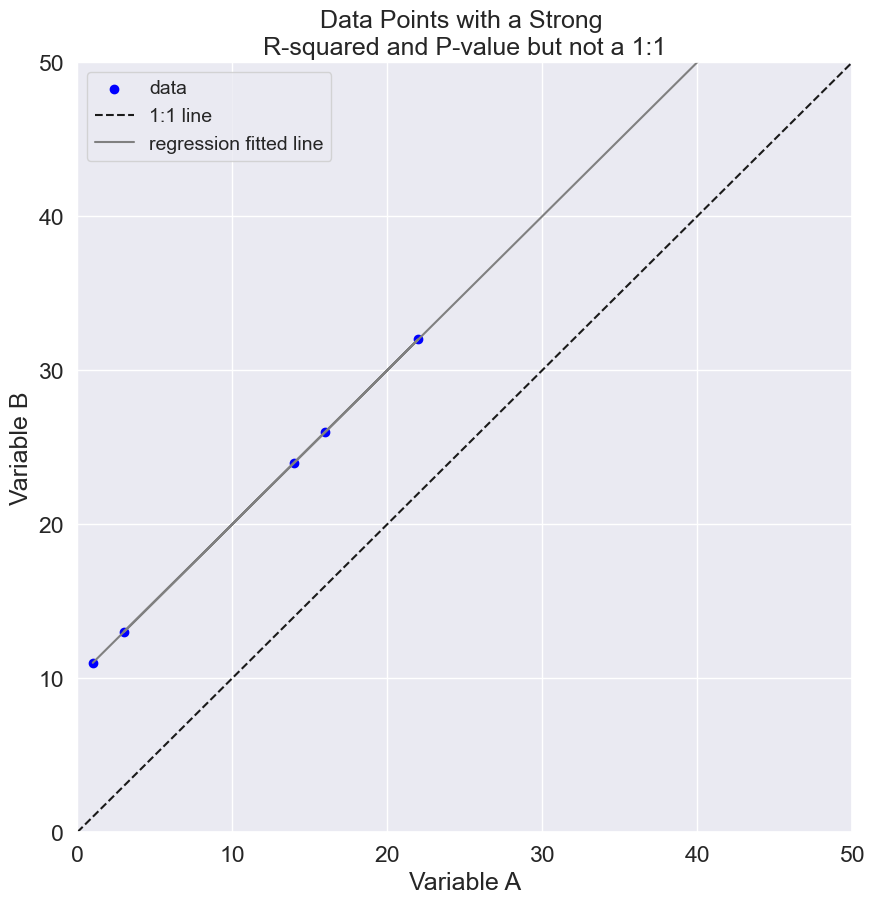

In [61]:
# Create some points with a one to one relationships
x = np.array([1, 22, 3, 14, 16, 45, 45])
y = np.array([item+10 for item in x])

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x, y, c='blue', label="data")
ax.plot((0, 1), (0, 1), transform=ax.transAxes,
        ls='--', c='k', label="1:1 line")

ax.plot(x, intercept + slope*x, 'grey', label='regression fitted line')
ax.set(xlim=[0, 50], ylim=[0, 50])
ax.set(xlabel="Variable A",
       ylabel="Variable B",
       title="Data Points with a Strong \nR-squared and P-value but not a 1:1")

plt.legend(fontsize=14)

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2,
      "\np-value:", p_value,
      "\nst_error", std_err,
      "\nRMSE", sqrt(std_err))

The data have a slope of 1 but there is a positive intercept (the x predictor tends to underestimate y).

Sometimes there may be positive bias in predictor

slope: 1.0 
intercept: -5.0 
r squared: 1.0 
p-value: 1.9206748078018256e-50 
st_error 0.0 
RMSE 0.0


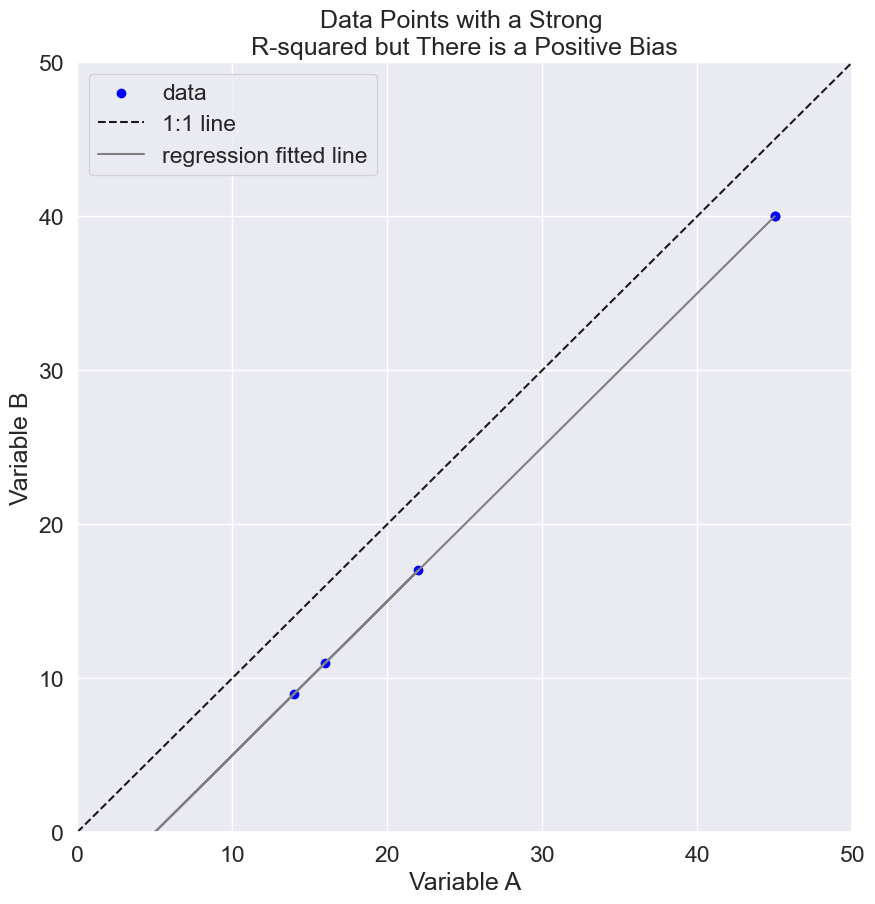

In [62]:
# Create some points with a one to one relationships
x = np.array([1, 22, 3, 14, 16, 45, 45])
y = np.array([item-5 for item in x])

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)


fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x, y, c='blue', label="data")
ax.plot((0, 1), (0, 1), transform=ax.transAxes,
        ls='--', c='k', label="1:1 line")

ax.plot(x, intercept + slope*x, 'grey', label='regression fitted line')

ax.set(xlim=[0, 50], ylim=[0, 50])
ax.set(xlabel="Variable A",
       ylabel="Variable B",
       title="Data Points with a Strong \nR-squared but There is a Positive Bias")
plt.legend()

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2,
      "\np-value:", p_value,
      "\nst_error", std_err,
      "\nRMSE", sqrt(std_err))

In the above, the x tends to overestimate y values (slope remains 1)

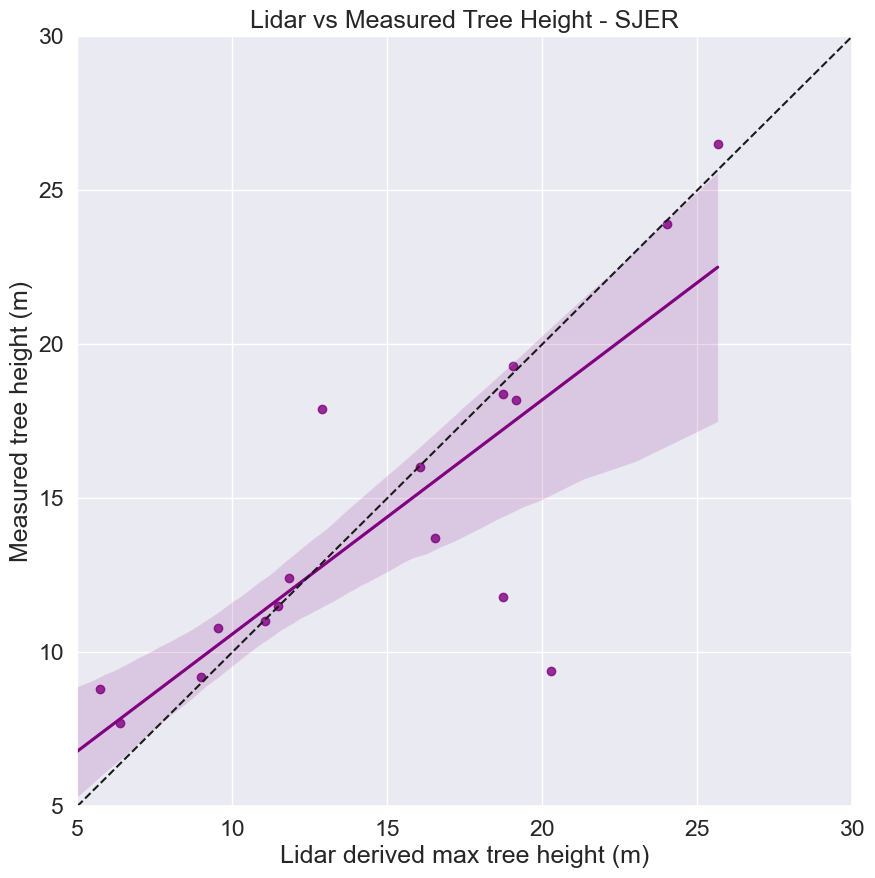

In [65]:
# Create the same plot in seaborn
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.regplot('lidar_max', 'insitu_max', data=sjer_final_height_df,
                 color="purple")

# Add a diagonal line
ax.set(xlim=[5, 30], ylim=[5, 30])
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--', c='k')

ax.set(xlabel="Lidar derived max tree height (m)",
       ylabel="Measured tree height (m)",
       title="Lidar vs Measured Tree Height - SJER")

plt.show()